<a href="https://colab.research.google.com/github/akanksha-ahuja/fcc-final-notebooks/blob/main/fcc_experiment_2_x_model_final_GCNX_16_32_on_variable_sized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import timeit
import random
import torch.nn.functional as F
import itertools
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install graphlime
from torch_geometric.data import Data, DataLoader
from graphlime import GraphLIME
from torch_geometric.utils import to_networkx

In [ ]:
from torch_geometric.nn import GCNConv, TAGConv, SAGEConv, ChebConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GINConv
from torch_geometric.nn import JumpingKnowledge, GCN2Conv
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import GNNExplainer

# Connect G drive

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load df and process the data

In [ ]:
# Data Processing Functions
def load_df(path_to_file):
  df = pd.read_csv(path_to_file)
  return df

def set_constants(TOTAL_EVENTS, MAX_LENGTH_EVENT=150):
  TOTAL_EVENTS = TOTAL_EVENTS
  MAX_LENGTH_EVENT = MAX_LENGTH_EVENT
  return TOTAL_EVENTS, MAX_LENGTH_EVENT

def create_labels(df):
  conditions = [(df['isHiggs'] == True),(df['isZ'] == True), (df['isOther'] == True) ]
  # create a list of the values we want to assign for each condition
  values = [0, 1, 2] 

  # create a new column and use np.select to assign values to it using our lists as arguments
  df['label'] = np.select(conditions, values)
  return df


def normalise_x_features(df):
  # Normalise the features in the dataset 
  df_id = df[['event_list']]
  df_x = df[['pid', 'pos_r', 'pos_theta', 'pos_phi', 'pos_t', 'mom_p', 'mom_theta', 'mom_phi', 'mom_mass']]
  df_y = df[['label']]

  # Create a list of labels for the new dataframe
  new_columns = ['event_list', 'pid', 'pos_r', 'pos_theta', 'pos_phi', 'pos_t', 'mom_p', 'mom_theta', 'mom_phi', 'mom_mass', 'label']

  x = df_x.values # returns numpy 
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df_x = pd.DataFrame(x_scaled)

  # Concatenate normalised x features and un-normalised y labels and event ids
  df_normalised_features = pd.concat([df_id, df_x, df_y], axis=1)
  df_normalised_features.columns = new_columns # You need to mention the axis
  return df_normalised_features

def split_df_by_event(df_normalised_features, TOTAL_EVENTS):
  # Dataframes split by event 
  df_event_list = []
  for i in range(TOTAL_EVENTS):
    df_event = df_normalised_features[df_normalised_features['event_list']==i]
    df_event_list.append(df_event)

  # A list of number of stable particles per event 
  length_of_each_event = [len(df_event_list[i]) for i in range(len(df_event_list))]
  return df_event_list, length_of_each_event

def create_source_target_for_COO(df_event_list):
  # Add two columns of source, target over all dataframes in df_event_list to make it compatible with pygn Data Object.
  df_event_source_target_list = []
  for i in range(len(df_event_list)):
    df_event_list[i]['source'] = None
    df_event_list[i]['target'] = None
    df_event_source_target_list.append(df_event_list[i])
  return df_event_source_target_list

# Binary classification by removing the other particles 

In [ ]:
def get_event_ids_to_be_removed(path_to_file, TOTAL_EVENTS):
  df = load_df(path_to_file)
  df = create_labels(df)
  df = normalise_x_features(df)
  df_event_list_complete = []
  for i in range(TOTAL_EVENTS):
      df_event = df[df['event_list']==i]
      df_event_list_complete.append(df_event)

  n_others_list = []
  for event in df_event_list_complete:
    labels = event['label'].to_list()
    for node_id in range(len(event)):
      if labels[node_id] == 2:
        n_others_list.append(event['event_list'].values)

  event_ids_others = np.asarray(n_others_list)
  event_ids_others_unique = []
  for event_ids in event_ids_others:
    event_ids_others_unique.append(np.unique(event_ids))

  event_ids_to_be_removed = np.unique(np.asarray(event_ids_others_unique))
  return df, event_ids_to_be_removed


def get_updated_TOTAL_EVENTS(event_ids_to_be_removed, TOTAL_EVENTS):
  NO_OF_EVENTS_REMOVED = len(event_ids_to_be_removed)
  TOTAL_EVENTS -= NO_OF_EVENTS_REMOVED
  return TOTAL_EVENTS

def drop_all_rows_with_event_ids(df, event_ids_to_be_removed):
  for event_id in event_ids_to_be_removed:
    # print(event_id)
    df.drop(df[df['event_list']== event_id].index, inplace=True)
  # Save the file for manual fix 
  df['event_list'].to_csv('fix_column.csv')
  return "Saved"

# The fixed column is a file for 10,000 events, and you are processing all those events 
# If you want to process lesser events, update this method to choose a specific number of event ids
def get_df_with_fixed_event_id_column(df, path_to_file):
  df_new_column = pd.read_csv("/content/fixed_column.csv")
  new_column = df_new_column['Unnamed: 2'].values
  # Drop ['event_list] 
  df = df.drop("event_list", axis=1)
  # df = df.drop("Unnamed: 0", axis=1)
  # Replace the existing column with a new column 
  df['event_list'] = new_column
  column_names = ["event_list","pid",	"pos_r",	"pos_theta",	"pos_phi",	"pos_t",	"mom_p",	"mom_theta",	"mom_phi"	,"mom_mass"	,"label"]
  df = df.reindex(columns=column_names)
  return df

def create_df_with_only_H_Z_events(path_to_file="/content/output_11_07_2021.csv", path_to_file_fixed_columns='/content/fixed_column.csv', TOTAL_EVENTS=10000):
  df, event_ids_to_be_removed = get_event_ids_to_be_removed(path_to_file, TOTAL_EVENTS)
  TOTAL_EVENTS = get_updated_TOTAL_EVENTS(event_ids_to_be_removed, TOTAL_EVENTS)
  drop_all_rows_with_event_ids(df, event_ids_to_be_removed)
  df = get_df_with_fixed_event_id_column(df, path_to_file_fixed_columns)
  return df, TOTAL_EVENTS 
  


#Fixed Graph Sizes need further processing

In [ ]:
# Fixed Graph Sizes need further processing 
def process_df_create_fixed_size_events(df_single_event, MAX_LENGTH_EVENT, append_with_digits= 9999.0, category_assigned=3, label_column=-3):
  df_processed = df_single_event
  df_processed = df_processed.drop('event_list', axis=1)

  # Append the rows
  n_rows_to_append = MAX_LENGTH_EVENT - len(df_processed)
  # Creating the appending df 
  np_append = np.ones((n_rows_to_append, len(df_processed.columns)))
  # print(np_append)
  np_append = np_append * append_with_digits
  for x in range(n_rows_to_append):
    np_append[x][label_column] = category_assigned # Label Column
    np_append[x][-2] = None # Source Column 
    np_append[x][-1] = None # Target Column 

  # print(np_append)
  df_append = pd.DataFrame(data=np_append, columns=df_processed.columns)
  # Concat the two dfs
  df_fixed_size_event = pd.concat([df_processed, df_append])
  # Reset the index 
  df_fixed_size_event.reset_index(drop=True) # Drop the old index colum
  return df_fixed_size_event

def process_all_events(df_event_list, TOTAL_EVENTS, MAX_LENGTH_EVENT):
  df_event_processed_list = []
  for i in range(TOTAL_EVENTS):
    df_processed = process_df_create_fixed_size_events(df_event_list[i], MAX_LENGTH_EVENT)
    df_event_processed_list.append(df_processed)
  return df_event_processed_list

def clean_columns(df_event_processed_list, TOTAL_EVENTS):
  for event_id in range(TOTAL_EVENTS):
    df_event_processed_list[event_id]['source'] = None
    df_event_processed_list[event_id]['target'] = None
  return df_event_processed_list

#Generate Data.x and Data.y for pytorch geometric 

In [ ]:
def generate_graph_data_x_y_for_already_normalised_features(df_event_processed_list_cleaned, TOTAL_EVENTS):
  # Generating data.x and data.y for pytorch geomteric 
  graph_data_x_list = []
  graph_data_y_list = []
  for i in range(TOTAL_EVENTS):
    df_graph = df_event_processed_list_cleaned[i]
    # Extract node features and labels from cleaned processed fixed size event list and convert to numpy 
    data_x = df_graph[['pid', 'pos_r', 'pos_theta', 'pos_phi', 'pos_t', 'mom_p', 'mom_theta', 'mom_phi', 'mom_mass']].to_numpy()
    data_y = df_graph[['label']].to_numpy()

    # Convert numpy objects into tensors for data loaders 
    graph_data_x_list.append(torch.Tensor(data_x))
    graph_data_y_list.append(torch.Tensor(data_y))
  return graph_data_x_list, graph_data_y_list

In [ ]:
# NORMALISES THE APPENDED PADDED NUMBERS - for FIXED SIZE GRAPHS 
def generate_graph_data_x_y(df_event_processed_list_cleaned, TOTAL_EVENTS):
  # Generating data.x and data.y for pytorch geomteric 
  graph_data_x_list = []
  graph_data_y_list = []
  for i in range(TOTAL_EVENTS):
    df_graph = df_event_processed_list_cleaned[i]
    df_x = df_graph[['pid', 'pos_r', 'pos_theta', 'pos_phi', 'pos_t', 'mom_p', 'mom_theta', 'mom_phi', 'mom_mass']]
    df_y = df_graph[['label']]

    # Normalise the features in the dataset 
    x = df_x.values # returns numpy 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_x = pd.DataFrame(x_scaled)

    # Convert the pandas dataframe to numpy 
    x_data = df_x.to_numpy()
    y_data = df_y.to_numpy()

    # Convert numpy objects into tensors for data loaders 
    x_data_tensor = torch.Tensor(x_data)
    y_data_tensor = torch.Tensor(y_data)

    # what is the difference btw FloatTensor and Tensor? 
    graph_data_x_list.append(x_data_tensor)
    graph_data_y_list.append(y_data_tensor)

  return graph_data_x_list, graph_data_y_list

# Create graph nodes and labels 

In [ ]:
def create_graph_nodes_and_labels_for_variable_graphs(path_to_file, TOTAL_EVENTS):
  df = load_df(path_to_file) # You can specify path to file here 
  TOTAL_EVENTS, _ = set_constants(TOTAL_EVENTS) # you can pass the constants here 
  df = create_labels(df) 
  df_normalised_features = normalise_x_features(df) # Don't call this if you are normalising features when creating graph dataset for FIXED GRAPHS  
  df_event_list, length_of_each_event = split_df_by_event(df_normalised_features, TOTAL_EVENTS)
  df_event_source_target_list = create_source_target_for_COO(df_event_list) 
  df_event_processed_list_cleaned = df_event_source_target_list
  graph_data_x_list, graph_data_y_list = generate_graph_data_x_y_for_already_normalised_features(df_event_processed_list_cleaned, TOTAL_EVENTS)
  return df, df_normalised_features, df_event_list, length_of_each_event, df_event_processed_list_cleaned, graph_data_x_list, graph_data_y_list

In [ ]:
def create_graph_nodes_and_labels_for_fixed_graphs(path_to_file, TOTAL_EVENTS, MAX_LENGTH_EVENT):
  df = load_df(path_to_file) # You can specify path to file here 
  TOTAL_EVENTS, MAX_LENGTH_EVENT = set_constants(TOTAL_EVENTS, MAX_LENGTH_EVENT) # you can pass the constants here 
  df = create_labels(df) 
  # df_normalised_features = normalise_x_features(df) # Don't call this if you are normalising features when creating graph dataset for FIXED GRAPHS  
  df_normalised_features = df
  df_event_list, length_of_each_event = split_df_by_event(df_normalised_features, TOTAL_EVENTS)
  df_event_source_target_list = create_source_target_for_COO(df_event_list) 
  df_event_processed_list = process_all_events(df_event_list, TOTAL_EVENTS, MAX_LENGTH_EVENT)
  df_event_processed_list_cleaned = clean_columns(df_event_processed_list, TOTAL_EVENTS)
  graph_data_x_list, graph_data_y_list = generate_graph_data_x_y(df_event_processed_list_cleaned, TOTAL_EVENTS)
  return df, df_normalised_features, df_event_list, length_of_each_event, df_event_processed_list_cleaned, graph_data_x_list, graph_data_y_list

In [ ]:
# create_df_with_only_H_Z_events
def create_graph_nodes_and_labels_for_variable_graphs_H_Z(path_to_file, path_to_file_fixed_columns, TOTAL_EVENTS):
  df, TOTAL_EVENTS = create_df_with_only_H_Z_events(path_to_file, path_to_file_fixed_columns, TOTAL_EVENTS)
  df_event_list, length_of_each_event = split_df_by_event(df, TOTAL_EVENTS)
  df_event_source_target_list = create_source_target_for_COO(df_event_list) 
  df_event_processed_list_cleaned = df_event_source_target_list
  graph_data_x_list, graph_data_y_list = generate_graph_data_x_y_for_already_normalised_features(df_event_processed_list_cleaned, TOTAL_EVENTS)
  return df, df_event_list, length_of_each_event, df_event_processed_list_cleaned, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS

# Label

In [ ]:
def generate_particle_lists_for_label_connections(df_event_list):
  # Getting all the lists for each event in the dataset - define h_list, z_list, o_list
  h_list = [] # all higgs nodes are connected Ω
  z_list = []  # all z nodes are connected 
  o_list = [] # all otehr nodes are connected 

  for i in range(len(df_event_list)):
    df_event = df_event_list[i]
    h = df_event[df_event['label']==0]
    h.reset_index(drop=True)
    z = df_event[df_event['label']==1]
    z.reset_index(drop=True)
    o = df_event[df_event['label']==2] 
    o.reset_index(drop=True)
    h_list.append(h)
    z_list.append(z)
    o_list.append(o)

  return h_list, z_list, o_list

def generate_X_label_list(h_list, z_list, o_list, df_event_list, TOTAL_EVENTS):
  Z_BOSON = int(1)
  H_BOSON = int(0)
  NO_BOSON = int(2)
  # NO_PARTICLE = int(3)
  X_list = []
  # for each event event_id 
  for event_id in range(TOTAL_EVENTS):
    X = df_event_list[event_id]
    source_list, target_list  = [], []
    # for each node_id 
    for node_id in range(len(X)):
      if X.iloc[node_id].label == Z_BOSON:
        source = [node_id for x in range(len(z_list[event_id]))]
        target = [x for x in range(len(z_list[event_id]))]
        source_list.append(source)
        target_list.append(target)
      elif X.iloc[node_id].label == H_BOSON:
        source = [node_id for x in range(len(h_list[event_id]))]
        target = [x for x in range(len(h_list[event_id]))]
        source_list.append(source)
        target_list.append(target)
      elif X.iloc[node_id].label == NO_BOSON:
        source = [node_id for x in range(len(o_list[event_id]))]
        target = [x for x in range(len(o_list[event_id]))]
        source_list.append(source)
        target_list.append(target)
      # Add all values as 2 columns for eache event   
    X['source'] = source_list
    X['target'] = target_list
    X_list.append(X)

  return X_list

def convert_coo_format_for_label_events(df):
    source_list = list(itertools.chain.from_iterable(df['source'].to_numpy())) 
    target_list = list(itertools.chain.from_iterable(df['target'].to_numpy()))
    edge_index= torch.tensor([source_list, target_list], dtype=torch.long)
    return edge_index
    
def create_COO_format_data_label_list(X_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS):
  # Data Represented as edges with same labels 
  # A list of graph data items to be passed on to the data loader 
  data_label_list = []
  for event_id in range(TOTAL_EVENTS):
    data_item = Data(x = graph_data_x_list[event_id], 
                     y = graph_data_y_list[event_id], 
                    edge_index = convert_coo_format_for_label_events(X_list[event_id]))
    data_label_list.append(data_item)
  return data_label_list

In [ ]:
def create_data_label_list(df_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS):
  # Create Data Label List 
  h_list, z_list, o_list  = generate_particle_lists_for_label_connections(df_event_list)
  X_list = generate_X_label_list(h_list, z_list, o_list, df_event_list, TOTAL_EVENTS)
  data_label_list = create_COO_format_data_label_list(X_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS)
  return data_label_list 

# Radius


In [ ]:
def get_features_extraction_list(df_event_list, TOTAL_EVENTS):
  feature_extraction_list = [] 
  for event_id in range(TOTAL_EVENTS):
    event_features = df_event_list[event_id][["pid",	"pos_r",	"pos_theta",	"pos_phi",	"pos_t"	,"mom_p",	"mom_theta",	"mom_phi",	"mom_mass"]]
    feature_extraction_list.append(event_features)
  return feature_extraction_list

def get_PCA_transformed_features(feature_extraction_list, TOTAL_EVENTS):
  X_pca_list = []   
  for event_id in range(TOTAL_EVENTS):
    pca = PCA() 
    X_pca = pca.fit_transform(feature_extraction_list[event_id])
    X_pca_list.append(X_pca)
  return X_pca_list

def get_2_D_coordinates(X_pca_list, length_of_each_event, TOTAL_EVENTS):
  # Find all 2-d coordinates 
  point_event_list = [] # stores all points for each event in a list of tuple points
  index_event_list = [] # stores all indices for each event in a list of tuple indices
  principal_components_list = [5, 6] # after data exploration, these two were chosen 
  for event_id in range(TOTAL_EVENTS):
    length = length_of_each_event[event_id]
    points = []
    index_list = []
    # print(length)
    for node_id_source in range(length):
      for node_id_target in range(length):
        pt = (X_pca_list[event_id][node_id_source, principal_components_list[0]],
              X_pca_list[event_id][node_id_target, principal_components_list[1]])
        index_list.append((node_id_source, node_id_target))
        points.append(pt)
    point_event_list.append(points)
    index_event_list.append(index_list)
  return point_event_list, index_event_list

def calculate_euclidean_distance(point_event_list, length_of_each_event, TOTAL_EVENTS):
  # Calculate euclidean distance between each consecutive pair 
  distance_event_list = []
  for event_id in range(TOTAL_EVENTS):
    event_length = length_of_each_event[event_id]
    distance_list = []
    for node_id_source in range(event_length):
      for node_id_target in range(event_length):
        # print(k, length_of_each_event[k], i, j)
        xpt = point_event_list[event_id][node_id_source][0]
        ypt = point_event_list[event_id][node_id_target][1]
        dist = distance.euclidean(xpt,ypt)
        distance_list.append(dist)
    distance_event_list.append(distance_list)
  return distance_event_list

def calculate_node_distances_by_event(distance_event_list, length_of_each_event, TOTAL_EVENTS):
  # Calculating the each node's distances for event_length for each event for 10,000 events
  distance_each_particle_event_list = []
  for event_id in range(TOTAL_EVENTS):
    distance_each_particle_list = np.array_split(distance_event_list[event_id], length_of_each_event[event_id]) 
    distance_each_particle_event_list.append(distance_each_particle_list)
  return distance_each_particle_event_list

def calculate_edges_by_radius(distance_each_particle_event_list, length_of_each_event, TOTAL_EVENTS, radius = 0.2):
  # Fixing radius at random or threshold to be 0.2, therefore all node_ids with distances less than this threshold, is added to the neighbour_list 
  neighbour_event_list = []
  target_event_list = []
  source_event_list = [] 
  for event_id in range(TOTAL_EVENTS):
    event_length = length_of_each_event[event_id]
    neighbour_list = []
    source_list = []
    target_list = []
    for node_id_source in range(event_length):
      for node_id_target in range(event_length):
        if distance_each_particle_event_list[event_id][node_id_source][node_id_target] <= radius:
            source_list.append(node_id_source)
            target_list.append(node_id_target)
            neighbour_list.append((node_id_source, node_id_target))
    neighbour_event_list.append(neighbour_list)
    target_event_list.append(target_list)
    source_event_list.append(source_list)
  return neighbour_event_list, target_event_list, source_event_list

def convert_coo_format_for_radius_events(source_event_list,target_event_list, event_id):
    edge_index= torch.tensor([source_event_list[event_id], target_event_list[event_id]], dtype=torch.long)
    return edge_index

def create_COO_format_data_radius_list(source_event_list,target_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS):
  # Data Represented as edges within Radius = 0.2 
  # A list of graph data items to be passed on to the data loader 
  data_radius_list = []
  for event_id in range(TOTAL_EVENTS):
    data_item = Data(x = graph_data_x_list[event_id], 
                    y = graph_data_y_list[event_id], 
                    edge_index = convert_coo_format_for_radius_events(source_event_list,target_event_list, event_id))
    data_radius_list.append(data_item)
  return data_radius_list

In [ ]:
def create_data_radius_list(df_event_list, length_of_each_event, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, radius = 0.2):
  # Create Data Radius List 
  feature_extraction_list = get_features_extraction_list(df_event_list, TOTAL_EVENTS)
  X_pca_list = get_PCA_transformed_features(feature_extraction_list, TOTAL_EVENTS) 
  point_event_list, index_event_list = get_2_D_coordinates(X_pca_list, length_of_each_event, TOTAL_EVENTS) 
  distance_event_list = calculate_euclidean_distance(point_event_list, length_of_each_event, TOTAL_EVENTS)
  distance_each_particle_event_list = calculate_node_distances_by_event(distance_event_list, length_of_each_event,  TOTAL_EVENTS)
  neighbour_event_list, target_event_list, source_event_list = calculate_edges_by_radius(distance_each_particle_event_list, length_of_each_event, TOTAL_EVENTS, radius = 0.2)
  data_radius_list = create_COO_format_data_radius_list(source_event_list,target_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS)
  return data_radius_list 

# KNN 


In [ ]:
def define_knn(num_neighbours=8):
  knn = NearestNeighbors(n_neighbors=num_neighbours, radius=1.0, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=None)
  return knn

def generate_X_list_knn(knn, df_event_list, TOTAL_EVENTS, num_neighbours=8):
  X_list_knn = [] 
  for event_id in range(TOTAL_EVENTS):
    X = df_event_list[event_id]
    X = X.drop(columns=['source', 'target'])
    knn.fit(X)
    neighbour = knn.kneighbors(X, n_neighbors=num_neighbours, return_distance=False)
    target = neighbour
    source = np.zeros((neighbour.shape))
    X['source'] = None
    X['target'] = None
    for i in range(len(X)):
      X['source'].iloc[i] = np.ones((neighbour.shape)) * i
      X['target'].iloc[i] = target[i]
    X_list_knn.append(X)
  return X_list_knn

def convert_COO_for_knn_events(df, num_neighbours=8):
  source_list = [] 
  for i in range(len(df)):
    for _ in range(num_neighbours):
      source_list.append(i)
  target_list = list(itertools.chain.from_iterable(df['target'].to_numpy()))
  edge_index= torch.tensor([source_list, target_list], dtype=torch.long)
  return edge_index

def create_COO_format_data_knn_list(X_list_knn, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, num_neighbours=8):
  # Data Represented as edges with K-nearest neighbours as 8 
  # A list of graph data items to be passed on to the data loader 
  data_knn_list = []
  for event_id in range(TOTAL_EVENTS):
    data_item = Data(x = graph_data_x_list[event_id], 
                    y = graph_data_y_list[event_id], 
                    edge_index = convert_COO_for_knn_events(X_list_knn[event_id], num_neighbours=8))
    data_knn_list.append(data_item)
  return data_knn_list

In [ ]:
def create_data_knn_list(df_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, num_neighbours=8):
  # Create data knn list 
  knn = define_knn(num_neighbours=8)
  X_list_knn = generate_X_list_knn(knn, df_event_list, TOTAL_EVENTS, num_neighbours=8)
  data_knn_list = create_COO_format_data_knn_list(X_list_knn, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, num_neighbours=8)
  return data_knn_list 

# Create all 3 data sets 

In [ ]:
def get_data_lists_for_fixed_size_graphs(path_to_file, TOTAL_EVENTS, MAX_LENGTH_EVENT):
  # FIXED SIZE GRAPHS
  df, df_normalised_features, df_event_list, length_of_each_event, df_event_processed_list_cleaned, graph_data_x_list, graph_data_y_list = create_graph_nodes_and_labels_for_fixed_graphs(path_to_file, TOTAL_EVENTS, MAX_LENGTH_EVENT)
  data_label_list = create_data_label_list(df_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS)
  data_radius_list = create_data_radius_list(df_event_list, length_of_each_event, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, radius = 0.2)
  data_knn_list  = create_data_knn_list(df_event_list,graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, num_neighbours=8)
  return data_radius_list, data_knn_list, data_label_list, df_event_list, length_of_each_event, df_event_processed_list_cleaned

Returning df_event_list, length_of_each_event, df_event_processed_list_cleaned for calculating mass of particles

In [ ]:
def get_data_lists_for_variable_size_graphs(path_to_file, TOTAL_EVENTS):
  # VARIABLE SIZE GRAPHS
  df, df_normalised_features, df_event_list, length_of_each_event, df_event_processed_list_cleaned, graph_data_x_list, graph_data_y_list = create_graph_nodes_and_labels_for_variable_graphs(path_to_file, TOTAL_EVENTS)
  data_label_list = create_data_label_list(df_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS)
  data_radius_list = create_data_radius_list(df_event_list, length_of_each_event, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, radius = 0.2)
  data_knn_list  = create_data_knn_list(df_event_list,graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, num_neighbours=8)
  return data_radius_list, data_knn_list, data_label_list, df_event_list, length_of_each_event, df_event_processed_list_cleaned

Create data lists for variable size graphs for H and Z particles only 

In [ ]:
def get_data_lists_for_variable_size_graphs_H_Z(path_to_file="/content/output_11_07_2021.csv", path_to_file_fixed_columns='/content/fixed_column.csv', TOTAL_EVENTS=10000):
  df, df_event_list, length_of_each_event, df_event_processed_list_cleaned, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS = create_graph_nodes_and_labels_for_variable_graphs_H_Z(path_to_file, path_to_file_fixed_columns, TOTAL_EVENTS)
  data_label_list = create_data_label_list(df_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS)
  data_radius_list = create_data_radius_list(df_event_list, length_of_each_event, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, radius = 0.2)
  data_knn_list  = create_data_knn_list(df_event_list,graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, num_neighbours=8)
  return data_radius_list, data_knn_list, data_label_list, df_event_list, length_of_each_event, df_event_processed_list_cleaned, TOTAL_EVENTS


# calculate true mass and predicted mass for variable graphs 

In [ ]:
def get_true_mass_list(data_list, df_event_processed_list_cleaned, TOTAL_EVENTS):
  total_true_mass_H_list = []
  total_true_mass_Z_list = []
  total_true_mass_O_list = []
  column_index_for_mass = -1 # fixed 
  column_index_for_label = 0 # fixed for true labels
  for event_id in range(TOTAL_EVENTS):
    true_mass_H_list = []
    true_mass_Z_list = []
    true_mass_O_list = []
    event_length = len(df_event_processed_list_cleaned[event_id])
    for node_id in range(event_length):
      if data_list[event_id].y[node_id].numpy()[column_index_for_label] == 0:
        true_mass_H_list.append(data_list[event_id].x[node_id].numpy()[column_index_for_mass])
      elif data_list[event_id].y[node_id].numpy()[column_index_for_label] == 1:
        true_mass_Z_list.append(data_list[event_id].x[node_id].numpy()[column_index_for_mass])
      elif data_list[event_id].y[node_id].numpy()[column_index_for_label] == 2:
        true_mass_O_list.append(data_list[event_id].x[node_id].numpy()[column_index_for_mass])
    total_true_mass_H_list.append(true_mass_H_list)
    total_true_mass_Z_list.append(true_mass_Z_list)
    total_true_mass_O_list.append(true_mass_O_list)
  return total_true_mass_H_list, total_true_mass_Z_list, total_true_mass_O_list

In [ ]:
def calculate_predicted_mass(data_list, df_event_processed_list_cleaned, pred_list, TOTAL_EVENTS):
  total_pred_mass_H_list = []
  total_pred_mass_Z_list = []
  total_pred_mass_O_list = []
  column_index_for_mass = -1 # fixed 
  for event_id in range(TOTAL_EVENTS):
    pred_mass_H_list = []
    pred_mass_Z_list = []
    pred_mass_O_list = []
    event_length = len(df_event_processed_list_cleaned[event_id])
    for node_id in range(event_length):
      pred = pred_list[event_id][node_id].numpy()
      if pred == 0:
        pred_mass_H_list.append(data_list[event_id].x[node_id].numpy()[column_index_for_mass])
      elif pred == 1:
        pred_mass_Z_list.append(data_list[event_id].x[node_id].numpy()[column_index_for_mass])
      elif pred == 2:
        pred_mass_O_list.append(data_list[event_id].x[node_id].numpy()[column_index_for_mass])
    total_pred_mass_H_list.append(pred_mass_H_list)
    total_pred_mass_Z_list.append(pred_mass_Z_list)
    total_pred_mass_O_list.append(pred_mass_O_list)
  return total_pred_mass_H_list, total_pred_mass_Z_list, total_pred_mass_O_list

# Model

In [ ]:
# For Fixed Graph Size
def set_model_constants():
  dataset_num_features = 9 
  dataset_num_classes = 4
  return dataset_num_features, dataset_num_classes

In [ ]:
# For Variable Graph Size 
def set_model_constants_variable():
  dataset_num_features = 9 
  dataset_num_classes = 3
  return dataset_num_features, dataset_num_classes

In [ ]:
# For Variable Graph Size - H and Z events
def set_model_constants_variable_H_Z():
  dataset_num_features = 9 
  dataset_num_classes = 2
  return dataset_num_features, dataset_num_classes

In [ ]:
# Define the models
class GCNX(torch.nn.Module):
    def __init__(self, dataset_num_features, hidden_channels, dataset_num_classes, dropout=0.5, num_layers=2):
        super(GCNX, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset_num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset_num_classes )
        self.convx = torch.nn.ModuleList([GCNConv(hidden_channels, hidden_channels) for _ in range(num_layers-2)])
        self.dropout_p = dropout
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        for iter_layer in self.convx:
            x = F.dropout(x, p= self.dropout_p, training=self.training)
            x = F.relu(iter_layer(x, edge_index))
        x = F.dropout(x, p= self.dropout_p, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


# Data Loaders

In [ ]:
def create_data_loaders(data_list, train_split=0.6):
  # get length of the list
  lenth_of_list = len(data_list)
  train_split = 0.6
  valid_split = 0.2
  test_split = 0.2

  # create indices for loaders 
  train_end_index = int(lenth_of_list * train_split)
  validate_start_index = train_end_index
  validate_end_index = validate_start_index + int(lenth_of_list * valid_split)
  test_start_index = validate_end_index

  train_loader = DataLoader(data_list[:train_end_index], batch_size=1, shuffle=False)
  validation_loader = DataLoader(data_list[validate_start_index:validate_end_index], batch_size=1, shuffle=False)
  test_loader = DataLoader(data_list[test_start_index:], batch_size=1, shuffle=False)
  
  return train_loader, validation_loader, test_loader, train_end_index, validate_start_index, validate_end_index, test_start_index 

# Train, Validate, Test, Cal Accuracy and Evaluate

In [ ]:
def train(model, optimizer, loader):
  model.train()
  pred_list, y_list, loss_list, y_list_numpy, pred_list_numpy = [], [],[], [], []
  for batch in loader:
    x, edges = batch.x, batch.edge_index
    y = batch.y
    y_list.append(y.squeeze(1).type(torch.LongTensor))
    y_list_numpy.append(y.squeeze(1).type(torch.LongTensor).numpy())
    optimizer.zero_grad()
    out = model(x, edges)
    loss = criterion(out, y.squeeze(1).type(torch.LongTensor))
    loss_list.append(loss)
    pred = out.argmax(dim=1)
    pred_list.append(pred)
    pred_list_numpy.append(pred.numpy()) 
    loss.backward()
    optimizer.step()  
  return loss_list, pred_list, y_list, y_list_numpy,  pred_list_numpy

def validate(model, optimizer, loader):
  model.train()
  pred_list, y_list, loss_list, y_list_numpy, pred_list_numpy = [], [],[], [], []
  for batch in loader:
    x, edges = batch.x, batch.edge_index
    y = batch.y
    y_list.append(y.squeeze(1).type(torch.LongTensor))
    y_list_numpy.append(y.squeeze(1).type(torch.LongTensor).numpy())
    optimizer.zero_grad()
    out = model(x, edges)
    loss = criterion(out, y.squeeze(1).type(torch.LongTensor))
    loss_list.append(loss)
    pred = out.argmax(dim=1)
    # convert tensor to numpy
    pred_list.append(pred) 
    pred_list_numpy.append(pred.numpy()) 
    loss.backward()
    optimizer.step()  
  return loss_list, pred_list, y_list, y_list_numpy, pred_list_numpy

def accuracy(pred_list, y_list):
  accuracy_list = []
  for event_id in range(len(pred_list)): # Because this works on the length of pred_list this logically surpasses the length mismatch issue
    length_of_each_event = len(pred_list[event_id])
    num_correct_list = []
    for node_id in range(length_of_each_event):
      p = pred_list[event_id][node_id].numpy()
      y = y_list[event_id][node_id].numpy()
      num_correct = p == y 
      num_correct_list.append(num_correct)
    acc = sum(num_correct_list)/length_of_each_event
    accuracy_list.append(acc)
  return accuracy_list

def train_on_n_epochs(n_epochs, model, optimizer, loader):
  # running for multiple epochs
  total_train_acc_list = []
  total_train_loss_list, total_train_pred_list, total_train_y_list, total_train_y_list_numpy, total_train_pred_list_numpy = [], [], [], [], []
  time_per_epoch_list = []
  for _ in range(n_epochs):
    train_acc_list = []
    starttime = timeit.default_timer()
    train_loss_list, train_pred_list, train_y_list, train_y_list_numpy, train_pred_list_numpy = train(model, optimizer, loader)
    time_per_epoch_list.append(timeit.default_timer() - starttime) 
    train_acc_list = accuracy(train_pred_list, train_y_list)
    total_train_acc_list.append(train_acc_list)
    total_train_loss_list.append(train_loss_list)
    total_train_y_list.append(train_y_list)
    total_train_pred_list.append(train_pred_list)
    total_train_y_list_numpy.append(train_y_list_numpy)
    total_train_pred_list_numpy.append(train_pred_list_numpy)
  return total_train_acc_list, total_train_loss_list, total_train_pred_list, total_train_y_list, total_train_y_list_numpy, total_train_pred_list_numpy, time_per_epoch_list

def test(model, loader):
  model.eval()
  pred_list, y_list = [], []
  y_list_numpy = []
  for batch in loader:
    x, edges = batch.x, batch.edge_index
    y = batch.y
    y_list.append(y.squeeze(1).type(torch.LongTensor))
    y_list_numpy.append(y.squeeze(1).type(torch.LongTensor).numpy())
    out = model(x, edges)
    pred = out.argmax(dim=1)
    pred_list.append(pred)    
  return pred_list, y_list, y_list_numpy

def evaluate_model_performace(model, loader):
  test_pred_list, test_y_list, test_y_list_numpy = test(model, loader)
  test_acc_list = []
  x = accuracy(test_pred_list, test_y_list)
  test_acc_list.append(x)
  return test_acc_list, test_pred_list, test_y_list, test_y_list_numpy

# Init Models

Inits models for variable and fixed size graphs 

In [ ]:
def init_GCNX_model(variable, num_layers):
  if variable == True:
    dataset_num_features, dataset_num_classes = set_model_constants_variable()
  elif variable == False:
    dataset_num_features, dataset_num_classes = set_model_constants()
  model = GCNX(dataset_num_features = dataset_num_features, hidden_channels = 16, dataset_num_classes = dataset_num_classes, num_layers = num_layers)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
  criterion = torch.nn.CrossEntropyLoss()
  return dataset_num_features, dataset_num_classes, model, optimizer, criterion

Init models for binary classification and on only H and Z particles 

In [ ]:
def init_GCN_model_H_Z(variable):
  dataset_num_features, dataset_num_classes = set_model_constants_variable_H_Z()
  dataset_num_features, dataset_num_classes = set_model_constants()
  model = GCNX(dataset_num_features, 16, dataset_num_classes)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
  criterion = torch.nn.CrossEntropyLoss()
  return dataset_num_features, dataset_num_classes, model, optimizer, criterion

# Experiment Radius, KNN, Label to save values

In [ ]:
def save_to_experiment_path_as_dataframe(saved_list, path, file_name, dtype):
  df = pd.DataFrame(data=saved_list, dtype=dtype)
  df.to_csv(path + file_name)
  return "Saved as " + path + file_name

#Radius

In [ ]:
def experiment_radius(data_list, df_event_list, model_radius, optimizer_radius, n_epochs = 1000, path_to_experiment = '/content/'):
    # Data loaders for radius (60:20:20)
    train_loader, validation_loader, test_loader,  train_end_index, validate_start_index, validate_end_index, test_start_index = create_data_loaders(data_list)

    # Calculate True Mass of each particle for each train/valid/test 
    train = df_event_list[:train_end_index]
    valid = df_event_list[validate_start_index:validate_end_index]
    test = df_event_list[test_start_index:]
    # Split the data lists of graph events by (60:20:20)
    data_list_train = data_list[:train_end_index]
    data_list_valid = data_list[validate_start_index:validate_end_index]
    data_list_test = data_list[test_start_index:]
    # Calculate true mass
    total_true_mass_H_list_train, total_true_mass_Z_list_train, total_true_mass_O_list_train = get_true_mass_list(data_list_train, train, len(train))
    total_true_mass_H_list_valid, total_true_mass_Z_list_valid, total_true_mass_O_list_valid = get_true_mass_list(data_list_valid, valid, len(valid))
    total_true_mass_H_list_test, total_true_mass_Z_list_test, total_true_mass_O_list_test = get_true_mass_list(data_list_test, test, len(test))

    # Training on Radius Dataset
    total_train_acc_list, total_train_loss_list, total_train_pred_list, total_train_y_list, total_train_y_list_numpy, total_train_pred_list_numpy, train_time_per_epoch_list = train_on_n_epochs(n_epochs, model_radius, optimizer_radius, train_loader)
    total_valid_acc_list, total_valid_loss_list, total_valid_pred_list, total_valid_y_list, total_valid_y_list_numpy, total_valid_pred_list_numpy, valid_time_per_epoch_list = train_on_n_epochs(n_epochs, model_radius, optimizer_radius, validation_loader)
    mean_train_epoch_time = sum(train_time_per_epoch_list)/len(train_time_per_epoch_list)
    mean_valid_epoch_time = sum(valid_time_per_epoch_list)/len(valid_time_per_epoch_list)

    # Testing on Radius Data set 
    test_acc_list, test_pred_list, test_y_list, test_y_list_numpy = evaluate_model_performace(model_radius, test_loader)

    # Calculate the set of predicted mass for each particle
    total_pred_mass_H_list_train, total_pred_mass_Z_list_train, total_pred_mass_O_list_train = calculate_predicted_mass(data_list_train, train, total_train_pred_list[-1], len(train))
    total_pred_mass_H_list_valid, total_pred_mass_Z_list_valid, total_pred_mass_O_list_valid = calculate_predicted_mass(data_list_valid, valid, total_valid_pred_list[-1], len(valid))
    total_pred_mass_H_list_test, total_pred_mass_Z_list_test, total_pred_mass_O_list_test = calculate_predicted_mass(data_list_test, test, test_pred_list, len(test))

    # Results
    train_acc_radius = ['radius_train', np.mean(total_train_acc_list[-1]),np.std(total_train_acc_list[-1])]
    valid_acc_radius = ['radius_valid', np.mean(total_valid_acc_list[-1]),np.std(total_valid_acc_list[-1])]
    test_acc_radius = ['radius_test', np.mean(test_acc_list), np.std(test_acc_list) ]
    df_result_radius = pd.DataFrame([train_acc_radius, valid_acc_radius, test_acc_radius ], columns=['type','mean', 'stdev'])

    # save to drive 
    df_result_radius.to_csv(path_to_experiment  + 'df_result_radius.csv' )
    print(df_result_radius)

    # fix file names 
    file_name1 = 'df_radius_train_acc.csv'
    file_name2 = 'df_radius_test_acc.csv'
    file_name3 = 'df_radius_train_loss.csv'
    file_name4 = 'df_radius_test_pred.csv'
    file_name5 = 'df_radius_test_y.csv'
    file_name6 = 'df_radius_train_pred.csv'
    file_name7 = 'df_radius_train_y.csv'
    file_name8 = 'df_radius_train_time_per_epoch_list.csv'
    file_name9 = 'df_radius_valid_time_per_epoch_list.csv'
    file_name10 = 'df_radius_valid_acc.csv'
    file_name11 = 'df_radius_valid_loss.csv'
    file_name12 = 'df_radius_valid_pred.csv'
    file_name13 = 'df_radius_valid_y.csv'
    file_name14 = 'df_radius_test_y_numpy.csv'
    file_name15 = 'df_radius_train_y_numpy.csv'
    file_name16 = 'df_radius_valid_y_numpy.csv'
    file_name17 = "df_radius_true_mass_H_list_train"
    file_name18 = "df_radius_true_mass_Z_list_train"
    file_name19 = "df_radius_true_mass_O_list_train"
    file_name20 = "df_radius_true_mass_H_list_valid"
    file_name21 = "df_radius_true_mass_Z_list_valid"
    file_name22 = "df_radius_true_mass_O_list_valid"
    file_name23 = "df_radius_true_mass_H_list_test"
    file_name24 = "df_radius_true_mass_Z_list_test"
    file_name25 = "df_radius_true_mass_O_list_test"
    file_name26 = "df_radius_pred_mass_H_list_train"
    file_name27 = "df_radius_pred_mass_Z_list_train"
    file_name28 = "df_radius_pred_mass_O_list_train"
    file_name29 = "df_radius_pred_mass_H_list_valid"
    file_name30 = "df_radius_pred_mass_Z_list_valid"
    file_name31 = "df_radius_pred_mass_O_list_valid"
    file_name32 = "df_radius_pred_mass_H_list_test"
    file_name33 = "df_radius_pred_mass_Z_list_test"
    file_name34 = "df_radius_pred_mass_O_list_test"
    file_name35 = 'df_radius_train_pred_numpy.csv'
    file_name36 = 'df_radius_valid_pred_numpy.csv'

    # use path_to_experiment
    save_to_experiment_path_as_dataframe(total_train_acc_list,  path_to_experiment, file_name1, dtype=float)
    save_to_experiment_path_as_dataframe(test_acc_list, path_to_experiment, file_name2, dtype=float)
    save_to_experiment_path_as_dataframe(total_train_loss_list, path_to_experiment, file_name3, dtype=float)
    save_to_experiment_path_as_dataframe(test_pred_list, path_to_experiment, file_name4, dtype=float)
    save_to_experiment_path_as_dataframe(test_y_list, path_to_experiment, file_name5, dtype=object)
    save_to_experiment_path_as_dataframe(total_train_pred_list, path_to_experiment, file_name6, dtype=object)
    save_to_experiment_path_as_dataframe(total_train_y_list, path_to_experiment, file_name7, dtype=object)
    save_to_experiment_path_as_dataframe(train_time_per_epoch_list, path_to_experiment, file_name8, dtype=float)
    save_to_experiment_path_as_dataframe(valid_time_per_epoch_list, path_to_experiment, file_name9, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_acc_list,  path_to_experiment, file_name10, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_loss_list, path_to_experiment, file_name11, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_pred_list, path_to_experiment, file_name12, dtype=object)
    save_to_experiment_path_as_dataframe(total_valid_y_list, path_to_experiment, file_name13, dtype=object)
    # test y labels 
    save_to_experiment_path_as_dataframe(test_y_list_numpy, path_to_experiment, file_name14, dtype=float)
    save_to_experiment_path_as_dataframe(total_train_y_list_numpy, path_to_experiment, file_name15, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_y_list_numpy, path_to_experiment, file_name16, dtype=float)
    # mass true
    save_to_experiment_path_as_dataframe(total_true_mass_H_list_train,  path_to_experiment, file_name17, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_Z_list_train,  path_to_experiment, file_name18, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_O_list_train,  path_to_experiment, file_name19, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_H_list_valid,  path_to_experiment, file_name20, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_Z_list_valid,  path_to_experiment, file_name21, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_O_list_valid,  path_to_experiment, file_name22, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_H_list_test,  path_to_experiment, file_name23, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_Z_list_test,  path_to_experiment, file_name24, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_O_list_test,  path_to_experiment, file_name25, dtype=float)

    # mass calculated
    save_to_experiment_path_as_dataframe(total_pred_mass_H_list_train,  path_to_experiment, file_name26, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_Z_list_train,  path_to_experiment, file_name27, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_O_list_train,  path_to_experiment, file_name28, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_H_list_valid,  path_to_experiment, file_name29, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_Z_list_valid,  path_to_experiment, file_name30, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_O_list_valid,  path_to_experiment, file_name31, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_H_list_test,  path_to_experiment, file_name32, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_Z_list_test,  path_to_experiment, file_name33, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_O_list_test,  path_to_experiment, file_name34, dtype=float)
    # numpy pred labels 
    save_to_experiment_path_as_dataframe(total_train_pred_list_numpy, path_to_experiment, file_name35, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_pred_list_numpy, path_to_experiment, file_name36, dtype=float)
   

    # Save Model 
    torch.save(model_radius.state_dict(), path_to_experiment + 'model_radius.pickle')
    return mean_train_epoch_time, mean_valid_epoch_time, df_result_radius


# KNN

In [ ]:
def experiment_knn(data_list, df_event_list, model_knn, optimizer_knn, n_epochs = 1000, path_to_experiment = '/content/'):
    # Data loaders for KNN (60:20:20)
    train_loader, validation_loader, test_loader,  train_end_index, validate_start_index, validate_end_index, test_start_index = create_data_loaders(data_list)

    # Calculate True Mass of each particle for each train/valid/test 
    train = df_event_list[:train_end_index]
    valid = df_event_list[validate_start_index:validate_end_index]
    test = df_event_list[test_start_index:]
    # Split the data lists of graph events by (60:20:20)
    data_list_train = data_list[:train_end_index]
    data_list_valid = data_list[validate_start_index:validate_end_index]
    data_list_test = data_list[test_start_index:]
    # Call method over the 3 lists 
    total_true_mass_H_list_train, total_true_mass_Z_list_train, total_true_mass_O_list_train = get_true_mass_list(data_list_train, train, len(train))
    total_true_mass_H_list_valid, total_true_mass_Z_list_valid, total_true_mass_O_list_valid = get_true_mass_list(data_list_valid, valid, len(valid))
    total_true_mass_H_list_test, total_true_mass_Z_list_test, total_true_mass_O_list_test = get_true_mass_list(data_list_test, test, len(test))

    # Training on KNN Dataset
    total_train_acc_list, total_train_loss_list, total_train_pred_list, total_train_y_list, total_train_y_list_numpy, total_train_pred_list_numpy, train_time_per_epoch_list = train_on_n_epochs(n_epochs, model_knn, optimizer_knn, train_loader)
    total_valid_acc_list, total_valid_loss_list, total_valid_pred_list, total_valid_y_list, total_valid_y_list_numpy, total_valid_pred_list_numpy, valid_time_per_epoch_list = train_on_n_epochs(n_epochs, model_knn, optimizer_knn, validation_loader)
    mean_train_epoch_time = sum(train_time_per_epoch_list)/len(train_time_per_epoch_list)
    mean_valid_epoch_time = sum(valid_time_per_epoch_list)/len(valid_time_per_epoch_list)

    # Testing on KNN Data set 
    test_acc_list, test_pred_list, test_y_list, test_y_list_numpy = evaluate_model_performace(model_knn, test_loader)
    
    # Calculate the set of predicted mass for each particle
    total_pred_mass_H_list_train, total_pred_mass_Z_list_train, total_pred_mass_O_list_train = calculate_predicted_mass(data_list_train, train, total_train_pred_list[-1], len(train))
    total_pred_mass_H_list_valid, total_pred_mass_Z_list_valid, total_pred_mass_O_list_valid = calculate_predicted_mass(data_list_valid, valid, total_valid_pred_list[-1], len(valid))
    total_pred_mass_H_list_test, total_pred_mass_Z_list_test, total_pred_mass_O_list_test = calculate_predicted_mass(data_list_test, test, test_pred_list, len(test))

    # Results
    train_acc_knn = ['knn_train', np.mean(total_train_acc_list[-1]),np.std(total_train_acc_list[-1])]
    valid_acc_knn = ['knn_valid', np.mean(total_valid_acc_list[-1]),np.std(total_valid_acc_list[-1])]
    test_acc_knn = ['knn_test', np.mean(test_acc_list), np.std(test_acc_list) ]

    df_result_knn = pd.DataFrame([train_acc_knn, valid_acc_knn, test_acc_knn ], columns=['type','mean', 'stdev'])

    # save to drive 
    df_result_knn.to_csv(path_to_experiment  + 'df_result_knn.csv' )
    print(df_result_knn)

    # fix file names 
    file_name1 = 'df_knn_train_acc.csv'
    file_name2 = 'df_knn_test_acc.csv'
    file_name3 = 'df_knn_train_loss.csv'
    file_name4 = 'df_knn_test_pred.csv'
    file_name5 = 'df_knn_test_y.csv'
    file_name6 = 'df_knn_train_pred.csv'
    file_name7 = 'df_knn_train_y.csv'
    file_name8 = 'df_knn_train_time_per_epoch_list.csv'
    file_name9 = 'df_knn_valid_time_per_epoch_list.csv'
    file_name10 = 'df_knn_valid_acc.csv'
    file_name11 = 'df_knn_valid_loss.csv'
    file_name12 = 'df_knn_valid_pred.csv'
    file_name13 = 'df_knn_valid_y.csv'
    file_name14 = 'df_knn_test_y_numpy.csv'
    file_name15 = 'df_knn_train_y_numpy.csv'
    file_name16 = 'df_knn_valid_y_numpy.csv'
    file_name17 = "df_knn_true_mass_H_list_train"
    file_name18 = "df_knn_true_mass_Z_list_train"
    file_name19 = "df_knn_true_mass_O_list_train"
    file_name20 = "df_knn_true_mass_H_list_valid"
    file_name21 = "df_knn_true_mass_Z_list_valid"
    file_name22 = "df_knn_true_mass_O_list_valid"
    file_name23 = "df_knn_true_mass_H_list_test"
    file_name24 = "df_knn_true_mass_Z_list_test"
    file_name25 = "df_knn_true_mass_O_list_test"
    file_name26 = "df_knn_pred_mass_H_list_train"
    file_name27 = "df_knn_pred_mass_Z_list_train"
    file_name28 = "df_knn_pred_mass_O_list_train"
    file_name29 = "df_knn_pred_mass_H_list_valid"
    file_name30 = "df_knn_pred_mass_Z_list_valid"
    file_name31 = "df_knn_pred_mass_O_list_valid"
    file_name32 = "df_knn_pred_mass_H_list_test"
    file_name33 = "df_knn_pred_mass_Z_list_test"
    file_name34 = "df_knn_pred_mass_O_list_test"
    file_name35 = 'df_knn_train_pred_numpy.csv'
    file_name36 = 'df_knn_valid_pred_numpy.csv'

    # use path_to_experiment
    save_to_experiment_path_as_dataframe(total_train_acc_list,  path_to_experiment, file_name1, dtype=float)
    save_to_experiment_path_as_dataframe(test_acc_list, path_to_experiment, file_name2, dtype=float)
    save_to_experiment_path_as_dataframe(total_train_loss_list, path_to_experiment, file_name3, dtype=float)
    save_to_experiment_path_as_dataframe(test_pred_list, path_to_experiment, file_name4, dtype=float)
    save_to_experiment_path_as_dataframe(test_y_list, path_to_experiment, file_name5, dtype=object)
    save_to_experiment_path_as_dataframe(total_train_pred_list, path_to_experiment, file_name6, dtype=object)
    save_to_experiment_path_as_dataframe(total_train_y_list, path_to_experiment, file_name7, dtype=object)
    save_to_experiment_path_as_dataframe(train_time_per_epoch_list, path_to_experiment, file_name8, dtype=float)
    save_to_experiment_path_as_dataframe(valid_time_per_epoch_list, path_to_experiment, file_name9, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_acc_list,  path_to_experiment, file_name10, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_loss_list, path_to_experiment, file_name11, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_pred_list, path_to_experiment, file_name12, dtype=object)
    save_to_experiment_path_as_dataframe(total_valid_y_list, path_to_experiment, file_name13, dtype=object)
    # test y labels 
    save_to_experiment_path_as_dataframe(test_y_list_numpy, path_to_experiment, file_name14, dtype=float)
    save_to_experiment_path_as_dataframe(total_train_y_list_numpy, path_to_experiment, file_name15, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_y_list_numpy, path_to_experiment, file_name16, dtype=float)
    # mass true
    save_to_experiment_path_as_dataframe(total_true_mass_H_list_train,  path_to_experiment, file_name17, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_Z_list_train,  path_to_experiment, file_name18, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_O_list_train,  path_to_experiment, file_name19, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_H_list_valid,  path_to_experiment, file_name20, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_Z_list_valid,  path_to_experiment, file_name21, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_O_list_valid,  path_to_experiment, file_name22, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_H_list_test,  path_to_experiment, file_name23, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_Z_list_test,  path_to_experiment, file_name24, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_O_list_test,  path_to_experiment, file_name25, dtype=float)

    # mass calculated
    save_to_experiment_path_as_dataframe(total_pred_mass_H_list_train,  path_to_experiment, file_name26, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_Z_list_train,  path_to_experiment, file_name27, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_O_list_train,  path_to_experiment, file_name28, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_H_list_valid,  path_to_experiment, file_name29, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_Z_list_valid,  path_to_experiment, file_name30, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_O_list_valid,  path_to_experiment, file_name31, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_H_list_test,  path_to_experiment, file_name32, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_Z_list_test,  path_to_experiment, file_name33, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_O_list_test,  path_to_experiment, file_name34, dtype=float)
    # numpy pred labels 
    save_to_experiment_path_as_dataframe(total_train_pred_list_numpy, path_to_experiment, file_name35, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_pred_list_numpy, path_to_experiment, file_name36, dtype=float)

    # Save model 
    torch.save(model_knn.state_dict(), path_to_experiment + 'model_knn.pickle')
    return mean_train_epoch_time, mean_valid_epoch_time, df_result_knn

# Label

In [ ]:
def experiment_label(data_list, df_event_list, model_label, optimizer_label, n_epochs = 1000, path_to_experiment = '/content/'):

    # Data loaders for label (60:20:20)
    train_loader, validation_loader, test_loader,  train_end_index, validate_start_index, validate_end_index, test_start_index = create_data_loaders(data_list)

    # Calculate True Mass of each particle for each train/valid/test 
    # Split the dataframe based on the (60:20:20)
    train = df_event_list[:train_end_index]
    valid = df_event_list[validate_start_index:validate_end_index]
    test = df_event_list[test_start_index:]
    # Split the data lists of graph events by (60:20:20)
    data_list_train = data_list[:train_end_index]
    data_list_valid = data_list[validate_start_index:validate_end_index]
    data_list_test = data_list[test_start_index:]
    # Call method to calculate true mass over the 3 lists 
    total_true_mass_H_list_train, total_true_mass_Z_list_train, total_true_mass_O_list_train = get_true_mass_list(data_list_train, train, len(train))
    total_true_mass_H_list_valid, total_true_mass_Z_list_valid, total_true_mass_O_list_valid = get_true_mass_list(data_list_valid, valid, len(valid))
    total_true_mass_H_list_test, total_true_mass_Z_list_test, total_true_mass_O_list_test = get_true_mass_list(data_list_test, test, len(test))

    # Training on Label Dataset
    total_train_acc_list, total_train_loss_list, total_train_pred_list, total_train_y_list, total_train_y_list_numpy,total_train_pred_list_numpy, train_time_per_epoch_list = train_on_n_epochs(n_epochs, model_label, optimizer_label, train_loader)
    total_valid_acc_list, total_valid_loss_list, total_valid_pred_list, total_valid_y_list, total_valid_y_list_numpy,total_valid_pred_list_numpy, valid_time_per_epoch_list = train_on_n_epochs(n_epochs, model_label, optimizer_label, validation_loader)
    mean_train_epoch_time = sum(train_time_per_epoch_list)/len(train_time_per_epoch_list)
    mean_valid_epoch_time = sum(valid_time_per_epoch_list)/len(valid_time_per_epoch_list)

    # Testing on Label Data set 
    test_acc_list, test_pred_list, test_y_list, test_y_list_numpy = evaluate_model_performace(model_label, test_loader)


    # Calculate the set of predicted mass for each particle
    total_pred_mass_H_list_train, total_pred_mass_Z_list_train, total_pred_mass_O_list_train = calculate_predicted_mass(data_list_train, train, total_train_pred_list[-1], len(train))
    total_pred_mass_H_list_valid, total_pred_mass_Z_list_valid, total_pred_mass_O_list_valid = calculate_predicted_mass(data_list_valid, valid, total_valid_pred_list[-1], len(valid))
    total_pred_mass_H_list_test, total_pred_mass_Z_list_test, total_pred_mass_O_list_test = calculate_predicted_mass(data_list_test, test, test_pred_list, len(test))
    

    # Results
    train_acc_label = ['label_train', np.mean(total_train_acc_list[-1]),np.std(total_train_acc_list[-1])]
    valid_acc_label = ['label_valid', np.mean(total_valid_acc_list[-1]),np.std(total_valid_acc_list[-1])]
    test_acc_label = ['label_test', np.mean(test_acc_list), np.std(test_acc_list) ]

    df_result_label = pd.DataFrame([train_acc_label, valid_acc_label, test_acc_label ], columns=['type','mean', 'stdev'])

    # save to drive 
    df_result_label.to_csv(path_to_experiment  + 'df_result_label.csv' )
    print(df_result_label)

    # fix file names 
    file_name1 = 'df_label_train_acc.csv'
    file_name2 = 'df_label_test_acc.csv'
    file_name3 = 'df_label_train_loss.csv'
    file_name4 = 'df_label_test_pred.csv'
    file_name5 = 'df_label_test_y.csv'
    file_name6 = 'df_label_train_pred.csv'
    file_name7 = 'df_label_train_y.csv'
    file_name8 = 'df_label_train_time_per_epoch_list.csv'
    file_name9 = 'df_label_valid_time_per_epoch_list.csv'
    file_name10 = 'df_label_valid_acc.csv'
    file_name11 = 'df_label_valid_loss.csv'
    file_name12 = 'df_label_valid_pred.csv'
    file_name13 = 'df_label_valid_y.csv'
    file_name14 = 'df_label_test_y_numpy.csv'
    file_name15 = 'df_label_train_y_numpy.csv'
    file_name16 = 'df_label_valid_y_numpy.csv'
    file_name17 = "df_label_true_mass_H_list_train"
    file_name18 = "df_label_true_mass_Z_list_train"
    file_name19 = "df_label_true_mass_O_list_train"
    file_name20 = "df_label_true_mass_H_list_valid"
    file_name21 = "df_label_true_mass_Z_list_valid"
    file_name22 = "df_label_true_mass_O_list_valid"
    file_name23 = "df_label_true_mass_H_list_test"
    file_name24 = "df_label_true_mass_Z_list_test"
    file_name25 = "df_label_true_mass_O_list_test"
    file_name26 = "df_label_pred_mass_H_list_train"
    file_name27 = "df_label_pred_mass_Z_list_train"
    file_name28 = "df_label_pred_mass_O_list_train"
    file_name29 = "df_label_pred_mass_H_list_valid"
    file_name30 = "df_label_pred_mass_Z_list_valid"
    file_name31 = "df_label_pred_mass_O_list_valid"
    file_name32 = "df_label_pred_mass_H_list_test"
    file_name33 = "df_label_pred_mass_Z_list_test"
    file_name34 = "df_label_pred_mass_O_list_test"
    file_name35 = 'df_label_train_pred_numpy.csv'
    file_name36 = 'df_label_valid_pred_numpy.csv'

    # use path_to_experiment
    save_to_experiment_path_as_dataframe(total_train_acc_list,  path_to_experiment, file_name1, dtype=float)
    save_to_experiment_path_as_dataframe(test_acc_list, path_to_experiment, file_name2, dtype=float)
    save_to_experiment_path_as_dataframe(total_train_loss_list, path_to_experiment, file_name3, dtype=float)
    save_to_experiment_path_as_dataframe(test_pred_list, path_to_experiment, file_name4, dtype=float)
    save_to_experiment_path_as_dataframe(test_y_list, path_to_experiment, file_name5, dtype=object)
    save_to_experiment_path_as_dataframe(total_train_pred_list, path_to_experiment, file_name6, dtype=object)
    save_to_experiment_path_as_dataframe(total_train_y_list, path_to_experiment, file_name7, dtype=object)
    save_to_experiment_path_as_dataframe(train_time_per_epoch_list, path_to_experiment, file_name8, dtype=float)
    save_to_experiment_path_as_dataframe(valid_time_per_epoch_list, path_to_experiment, file_name9, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_acc_list,  path_to_experiment, file_name10, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_loss_list, path_to_experiment, file_name11, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_pred_list, path_to_experiment, file_name12, dtype=object)
    save_to_experiment_path_as_dataframe(total_valid_y_list, path_to_experiment, file_name13, dtype=object)
    # test y labels 
    save_to_experiment_path_as_dataframe(test_y_list_numpy, path_to_experiment, file_name14, dtype=float)
    save_to_experiment_path_as_dataframe(total_train_y_list_numpy, path_to_experiment, file_name15, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_y_list_numpy, path_to_experiment, file_name16, dtype=float)
    # mass true
    save_to_experiment_path_as_dataframe(total_true_mass_H_list_train,  path_to_experiment, file_name17, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_Z_list_train,  path_to_experiment, file_name18, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_O_list_train,  path_to_experiment, file_name19, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_H_list_valid,  path_to_experiment, file_name20, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_Z_list_valid,  path_to_experiment, file_name21, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_O_list_valid,  path_to_experiment, file_name22, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_H_list_test,  path_to_experiment, file_name23, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_Z_list_test,  path_to_experiment, file_name24, dtype=float)
    save_to_experiment_path_as_dataframe(total_true_mass_O_list_test,  path_to_experiment, file_name25, dtype=float)

    # mass calculated
    save_to_experiment_path_as_dataframe(total_pred_mass_H_list_train,  path_to_experiment, file_name26, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_Z_list_train,  path_to_experiment, file_name27, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_O_list_train,  path_to_experiment, file_name28, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_H_list_valid,  path_to_experiment, file_name29, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_Z_list_valid,  path_to_experiment, file_name30, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_O_list_valid,  path_to_experiment, file_name31, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_H_list_test,  path_to_experiment, file_name32, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_Z_list_test,  path_to_experiment, file_name33, dtype=float)
    save_to_experiment_path_as_dataframe(total_pred_mass_O_list_test,  path_to_experiment, file_name34, dtype=float)
    # numpy pred labels 
    save_to_experiment_path_as_dataframe(total_train_pred_list_numpy, path_to_experiment, file_name35, dtype=float)
    save_to_experiment_path_as_dataframe(total_valid_pred_list_numpy, path_to_experiment, file_name36, dtype=float)

    # Save model to path 
    torch.save(model_label.state_dict(), path_to_experiment + 'model_label.pickle')

    return mean_train_epoch_time, mean_valid_epoch_time, df_result_label

#Create Graphs - 
mention FILE NAME and TOTAL EVENTS to be processed and MAX EVENT LENGTh for fixed graphs 

In [ ]:
# MENTION FILE NAME Fixed Graph - Create the 3 lists that will be passed through the data loaders for processing
path_to_file="output_11_07_2021.csv"
data_radius_list, data_knn_list, data_label_list, df_event_list, length_of_each_event, df_event_processed_list_cleaned = get_data_lists_for_fixed_size_graphs(path_to_file, TOTAL_EVENTS=10000, MAX_LENGTH_EVENT=150)

In [ ]:
# MENTION FILE NAME Variable Graph - Create the 3 lists that will be passed through the data loaders for processing
path_to_file="output_11_07_2021.csv"
data_radius_list_variable, data_knn_list_variable, data_label_list_variable, df_event_list_variable, length_of_each_event_variable, df_event_processed_list_cleaned_variable = get_data_lists_for_variable_size_graphs(path_to_file, TOTAL_EVENTS=10000)

In [ ]:
# MENTION FILE NAME Variable Graph - only H and Z events - WILL PROCESS 10 k events at the moment 
data_radius_list_variable_H_Z, data_knn_list_variable_H_Z, data_label_list_variable_H_Z, df_event_list_variable_H_Z, length_of_each_event_variable_H_Z, df_event_processed_list_cleaned_variable_H_Z, TOTAL_EVENTS =  get_data_lists_for_variable_size_graphs_H_Z(path_to_file="/content/output_11_07_2021.csv", path_to_file_fixed_columns='/content/fixed_column.csv', TOTAL_EVENTS=10000)

# GCN 
1. 4 layer - variable
2. 8 layer -  variable
3. 16 layer - variable
4. 32 layer - variable 

#Init models for variable sized graph 

## 4 Layer GCN on Variable Graph - on 10 events

In [ ]:
dataset_num_features, dataset_num_classes, model_radius_variable_depth_4_gcn, optimizer_radius_variable_depth_4_gcn, criterion= init_GCNX_model(variable=True, num_layers=4)
dataset_num_features, dataset_num_classes, model_knn_variable_depth_4_gcn, optimizer_knn_variable_depth_4_gcn, criterion= init_GCNX_model(variable=True, num_layers=4)
dataset_num_features, dataset_num_classes, model_label_variable_depth_4_gcn, optimizer_label_variable_depth_4_gcn, criterion= init_GCNX_model(variable=True, num_layers=4)


Run the experiment on variable graphs 

In [ ]:
path_to_experiment_variable_depth_4_gcn_radius = '/content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_4/radius/'
train_epoch_radius_4, valid_epoch_radius_4, df_result_radius_4 = experiment_radius(data_radius_list_variable, df_event_processed_list_cleaned_variable, model_radius_variable_depth_4_gcn, optimizer_radius_variable_depth_4_gcn, n_epochs = 51, path_to_experiment = path_to_experiment_variable_depth_4_gcn_radius)

In [ ]:
path_to_experiment_variable_depth_4_gcn_knn = '/content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_4/knn/'
train_epoch_knn_4, valid_epoch_knn_4, df_result_knn_4 = experiment_knn(data_knn_list_variable, df_event_processed_list_cleaned_variable, model_knn_variable_depth_4_gcn, optimizer_knn_variable_depth_4_gcn, n_epochs = 51, path_to_experiment = path_to_experiment_variable_depth_4_gcn_knn)

In [ ]:
path_to_experiment_variable_depth_4_gcn_label = '/content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_4/label/'
train_epoch_label_4, valid_epoch_label_4, df_result_label_4 = experiment_label(data_label_list_variable, df_event_processed_list_cleaned_variable, model_label_variable_depth_4_gcn, optimizer_label_variable_depth_4_gcn, n_epochs = 51, path_to_experiment = path_to_experiment_variable_depth_4_gcn_label)

## 8 Layer GCN for Variable Sized Graph  - on 10 events

In [ ]:
dataset_num_features, dataset_num_classes, model_radius_variable_depth_8_gcn, optimizer_radius_variable_depth_8_gcn, criterion= init_GCNX_model(variable=True, num_layers=8)
dataset_num_features, dataset_num_classes, model_knn_variable_depth_8_gcn, optimizer_knn_variable_depth_8_gcn, criterion= init_GCNX_model(variable=True, num_layers=8)
dataset_num_features, dataset_num_classes, model_label_variable_depth_8_gcn, optimizer_label_variable_depth_8_gcn, criterion= init_GCNX_model(variable=True, num_layers=8)


In [ ]:
path_to_experiment_variable_depth_8_gcn_radius = '/content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_8/radius/'
train_epoch_radius_8, valid_epoch_radius_8, df_result_radius_8 = experiment_radius(data_radius_list_variable, df_event_processed_list_cleaned_variable, model_radius_variable_depth_8_gcn, optimizer_radius_variable_depth_8_gcn, n_epochs = 51, path_to_experiment = path_to_experiment_variable_depth_8_gcn_radius)

           type      mean     stdev
0  radius_train  0.964175  0.003384
1  radius_valid  0.966842  0.006842
2   radius_test  0.971705  0.005039


In [ ]:
path_to_experiment_variable_depth_8_gcn_knn = '/content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_8/knn/'
train_epoch_knn_8, valid_epoch_knn_8, df_result_knn_8 = experiment_knn(data_knn_list_variable, df_event_processed_list_cleaned_variable, model_knn_variable_depth_8_gcn, optimizer_knn_variable_depth_8_gcn, n_epochs = 51, path_to_experiment = path_to_experiment_variable_depth_8_gcn_knn)

        type      mean     stdev
0  knn_train  0.996667  0.007454
1  knn_valid  1.000000  0.000000
2   knn_test  1.000000  0.000000


In [ ]:
path_to_experiment_variable_depth_8_gcn_label = '/content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_8/label/'
train_epoch_label_8, valid_epoch_label_8, df_result_label_8 = experiment_label(data_label_list_variable, df_event_processed_list_cleaned_variable, model_label_variable_depth_8_gcn, optimizer_label_variable_depth_8_gcn, n_epochs = 51, path_to_experiment = path_to_experiment_variable_depth_8_gcn_label)

          type      mean     stdev
0  label_train  0.964175  0.003384
1  label_valid  0.966842  0.006842
2   label_test  0.971705  0.005039


## 16 Layer GCN - variable sized 



In [ ]:
dataset_num_features, dataset_num_classes, model_radius_variable_depth_16_gcn, optimizer_radius_variable_depth_16_gcn, criterion= init_GCNX_model(variable=True, num_layers=16)
dataset_num_features, dataset_num_classes, model_knn_variable_depth_16_gcn, optimizer_knn_variable_depth_16_gcn, criterion= init_GCNX_model(variable=True, num_layers=16)
dataset_num_features, dataset_num_classes, model_label_variable_depth_16_gcn, optimizer_label_variable_depth_16_gcn, criterion= init_GCNX_model(variable=True, num_layers=16)

In [ ]:
path_to_experiment_variable_depth_16_gcn_radius = '/content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_16/radius/'
train_epoch_radius_16, valid_epoch_radius_16, df_result_radius_16 = experiment_radius(data_radius_list_variable, df_event_processed_list_cleaned_variable, model_radius_variable_depth_16_gcn, optimizer_radius_variable_depth_16_gcn, n_epochs = 51, path_to_experiment = path_to_experiment_variable_depth_16_gcn_radius)

           type      mean     stdev
0  radius_train  0.958230  0.017910
1  radius_valid  0.958965  0.015107
2   radius_test  0.958934  0.011708


In [ ]:
path_to_experiment_variable_depth_16_gcn_knn = '/content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_16/knn/'
train_epoch_knn_16, valid_epoch_knn_16, df_result_knn_16 = experiment_knn(data_knn_list_variable, df_event_processed_list_cleaned_variable, model_knn_variable_depth_16_gcn, optimizer_knn_variable_depth_16_gcn, n_epochs = 51, path_to_experiment = path_to_experiment_variable_depth_16_gcn_knn)

        type      mean     stdev
0  knn_train  0.958113  0.018014
1  knn_valid  0.958965  0.015107
2   knn_test  0.958934  0.011708


In [ ]:
path_to_experiment_variable_depth_16_gcn_label = '/content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_16/label/'
train_epoch_label_16, valid_epoch_label_16, df_result_label_16 = experiment_label(data_label_list_variable, df_event_processed_list_cleaned_variable, model_label_variable_depth_16_gcn, optimizer_label_variable_depth_16_gcn, n_epochs = 51, path_to_experiment = path_to_experiment_variable_depth_16_gcn_label)

          type      mean     stdev
0  label_train  0.958230  0.017910
1  label_valid  0.958965  0.015107
2   label_test  0.958934  0.011708


## 32 Layer GCN - variable sized - crashes for 10k events due to execess memory for 51 epochs.

In [ ]:
dataset_num_features, dataset_num_classes, model_radius_variable_depth_32_gcn, optimizer_radius_variable_depth_32_gcn, criterion= init_GCNX_model(variable=True, num_layers=32)
dataset_num_features, dataset_num_classes, model_knn_variable_depth_32_gcn, optimizer_knn_variable_depth_32_gcn, criterion= init_GCNX_model(variable=True, num_layers=32)
dataset_num_features, dataset_num_classes, model_label_variable_depth_32_gcn, optimizer_label_variable_depth_32_gcn, criterion= init_GCNX_model(variable=True, num_layers=32)

In [ ]:
path_to_experiment_variable_depth_32_gcn_radius = '/content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_32/radius/'
train_epoch_radius_32, valid_epoch_radius_32, df_result_radius_32 = experiment_radius(data_radius_list_variable, df_event_processed_list_cleaned_variable, model_radius_variable_depth_32_gcn, optimizer_radius_variable_depth_32_gcn, n_epochs = 51, path_to_experiment = path_to_experiment_variable_depth_32_gcn_radius)

In [ ]:
path_to_experiment_variable_depth_32_gcn_knn = '/content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_32/knn/'
train_epoch_knn_32, valid_epoch_knn_32, df_result_knn_32 = experiment_knn(data_knn_list_variable, df_event_processed_list_cleaned_variable, model_knn_variable_depth_32_gcn, optimizer_knn_variable_depth_32_gcn, n_epochs = 51, path_to_experiment = path_to_experiment_variable_depth_32_gcn_knn)

In [ ]:
path_to_experiment_variable_depth_32_gcn_label = '/content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_32/label/'
train_epoch_label_32, valid_epoch_label_32, df_result_label_32 = experiment_label(data_label_list_variable, df_event_processed_list_cleaned_variable, model_label_variable_depth_32_gcn, optimizer_label_variable_depth_32_gcn, n_epochs = 51, path_to_experiment = path_to_experiment_variable_depth_32_gcn_label)

# GNNExplainer

In [ ]:
def explain_node_graphs(data_list, event_id, model, n_epochs, node_id, path_to_fig, file_name):
  explainer = GNNExplainer(model, epochs=n_epochs, return_type='log_prob')
  # Get data.x, data.y, data.edge_index
  data = data_list[event_id]
  node_feat_mask_N, edge_mask_N = explainer.explain_node(node_id, data.x, data.edge_index)
  # Plot the graphs 
  ax, G = explainer.visualize_subgraph(node_id, data.edge_index, edge_mask_N, data.y)
  unique_id = "event_id_" + str(event_id) + "_node_id_" + str(node_id)
  plt.savefig(fname=path_to_fig + file_name + unique_id, dpi=500, format='png')
  print("Saved as " + path_to_fig + file_name + unique_id)
  plt.show()

## 4 Layer GCN explanations

Explain node 12: 100%|██████████| 51/51 [00:00<00:00, 263.09it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_4/knn/gnn_explainer_knn_variableevent_id_9_node_id_12


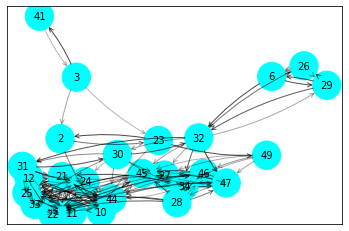

Explain node 11: 100%|██████████| 51/51 [00:00<00:00, 291.08it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_4/knn/gnn_explainer_knn_variableevent_id_9_node_id_11


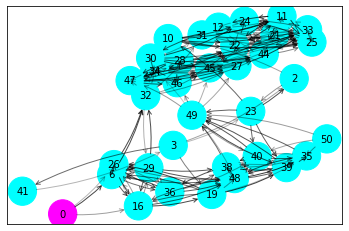

Explain node 21: 100%|██████████| 51/51 [00:00<00:00, 289.27it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_4/knn/gnn_explainer_knn_variableevent_id_9_node_id_21


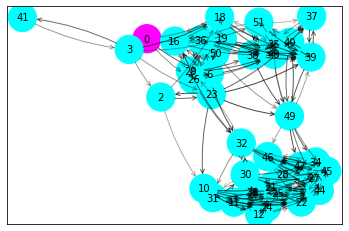

Explain node 0: 100%|██████████| 51/51 [00:00<00:00, 333.76it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_4/knn/gnn_explainer_knn_variableevent_id_9_node_id_0


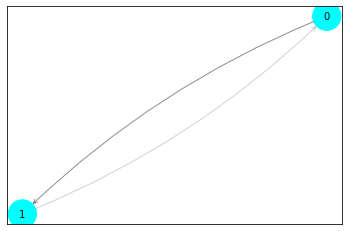

In [ ]:
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_4_gcn, n_epochs=51, node_id=12, path_to_fig=path_to_experiment_variable_depth_4_gcn_knn, file_name = 'gnn_explainer_knn_variable')
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_4_gcn, n_epochs=51, node_id=11, path_to_fig=path_to_experiment_variable_depth_4_gcn_knn, file_name = 'gnn_explainer_knn_variable')
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_4_gcn, n_epochs=51, node_id=21, path_to_fig=path_to_experiment_variable_depth_4_gcn_knn, file_name = 'gnn_explainer_knn_variable')
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_4_gcn, n_epochs=51, node_id=0, path_to_fig=path_to_experiment_variable_depth_4_gcn_knn, file_name = 'gnn_explainer_knn_variable')

## 8 Layer GCN explanations

Explain node 12: 100%|██████████| 51/51 [00:00<00:00, 167.70it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_8/knn/gnn_explainer_knn_variableevent_id_9_node_id_12


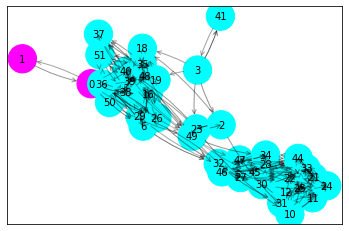

Explain node 11: 100%|██████████| 51/51 [00:00<00:00, 173.02it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_8/knn/gnn_explainer_knn_variableevent_id_9_node_id_11


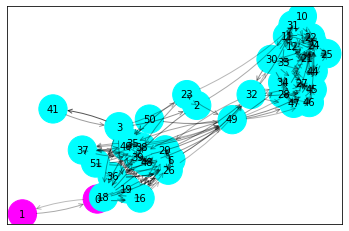

Explain node 21: 100%|██████████| 51/51 [00:00<00:00, 170.68it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_8/knn/gnn_explainer_knn_variableevent_id_9_node_id_21


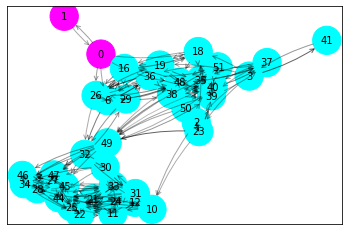

Explain node 0: 100%|██████████| 51/51 [00:00<00:00, 194.38it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_8/knn/gnn_explainer_knn_variableevent_id_9_node_id_0


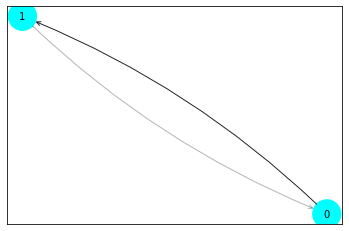

In [ ]:
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_8_gcn, n_epochs=51, node_id=12, path_to_fig=path_to_experiment_variable_depth_8_gcn_knn, file_name = 'gnn_explainer_knn_variable')
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_8_gcn, n_epochs=51, node_id=11, path_to_fig=path_to_experiment_variable_depth_8_gcn_knn, file_name = 'gnn_explainer_knn_variable')
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_8_gcn, n_epochs=51, node_id=21, path_to_fig=path_to_experiment_variable_depth_8_gcn_knn, file_name = 'gnn_explainer_knn_variable')
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_8_gcn, n_epochs=51, node_id=0, path_to_fig=path_to_experiment_variable_depth_8_gcn_knn, file_name = 'gnn_explainer_knn_variable')

## 16 Layer GCN explanations

Explain node 12: 100%|██████████| 51/51 [00:00<00:00, 96.00it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_16/knn/gnn_explainer_knn_variableevent_id_9_node_id_12


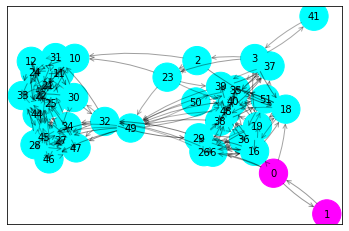

Explain node 11: 100%|██████████| 51/51 [00:00<00:00, 94.20it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_16/knn/gnn_explainer_knn_variableevent_id_9_node_id_11


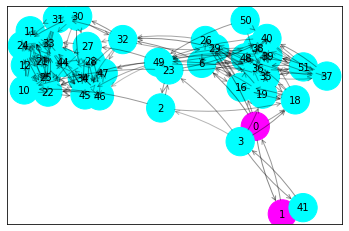

Explain node 21: 100%|██████████| 51/51 [00:00<00:00, 94.00it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_16/knn/gnn_explainer_knn_variableevent_id_9_node_id_21


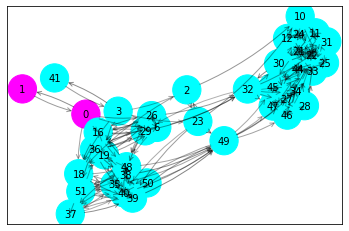

Explain node 0: 100%|██████████| 51/51 [00:00<00:00, 111.41it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_16/knn/gnn_explainer_knn_variableevent_id_9_node_id_0


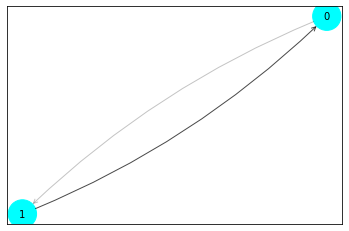

In [ ]:
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_16_gcn, n_epochs=51, node_id=12, path_to_fig=path_to_experiment_variable_depth_16_gcn_knn, file_name = 'gnn_explainer_knn_variable')
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_16_gcn, n_epochs=51, node_id=11, path_to_fig=path_to_experiment_variable_depth_16_gcn_knn, file_name = 'gnn_explainer_knn_variable')
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_16_gcn, n_epochs=51, node_id=21, path_to_fig=path_to_experiment_variable_depth_16_gcn_knn, file_name = 'gnn_explainer_knn_variable')
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_16_gcn, n_epochs=51, node_id=0, path_to_fig=path_to_experiment_variable_depth_16_gcn_knn, file_name = 'gnn_explainer_knn_variable')

## 32 Layer GCN explanations

Explain node 12: 100%|██████████| 51/51 [00:01<00:00, 49.42it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_32/knn/gnn_explainer_knn_variableevent_id_9_node_id_12


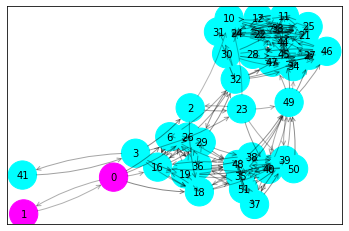

Explain node 11: 100%|██████████| 51/51 [00:01<00:00, 50.58it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_32/knn/gnn_explainer_knn_variableevent_id_9_node_id_11


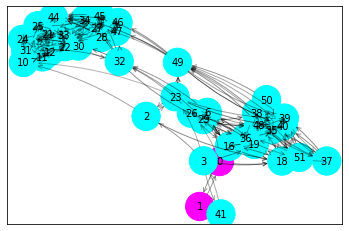

Explain node 21: 100%|██████████| 51/51 [00:01<00:00, 50.65it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_32/knn/gnn_explainer_knn_variableevent_id_9_node_id_21


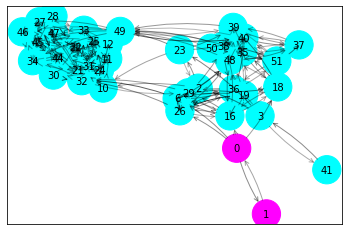

Explain node 0: 100%|██████████| 51/51 [00:00<00:00, 60.81it/s]


Saved as /content/drive/MyDrive/FCC_Experiments_2021/model_gcn/variable/depth_32/knn/gnn_explainer_knn_variableevent_id_9_node_id_0


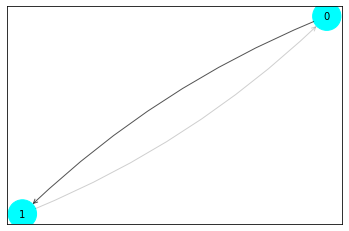

In [ ]:
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_32_gcn, n_epochs=51, node_id=12, path_to_fig=path_to_experiment_variable_depth_32_gcn_knn, file_name = 'gnn_explainer_knn_variable')
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_32_gcn, n_epochs=51, node_id=11, path_to_fig=path_to_experiment_variable_depth_32_gcn_knn, file_name = 'gnn_explainer_knn_variable')
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_32_gcn, n_epochs=51, node_id=21, path_to_fig=path_to_experiment_variable_depth_32_gcn_knn, file_name = 'gnn_explainer_knn_variable')
explain_node_graphs(data_knn_list_variable, event_id=9, model= model_knn_variable_depth_32_gcn, n_epochs=51, node_id=0, path_to_fig=path_to_experiment_variable_depth_32_gcn_knn, file_name = 'gnn_explainer_knn_variable')